In [1]:
from VenusOpt.model import generate_gpr_model
from VenusOpt.utils import loadXy

# run this script from root directory
from VenusOpt.utils import loadXy, RBF_BEST_PARAMS, MATERN_BEST_PARAMS
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_validate
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from plot4d import plotter

current_runs = ["1","2","3"]
other_runs = ["5","6","8"] # "7.0","7.5",
current_columns = ["mid_i_mean", "ext_i_mean","inj_i_mean"]
other_columns = ['bias_v_mean', 'gas_balzer_2_mean']

### Matern Kernel Fit

In [17]:
results = {}
lc_range = np.linspace(0.02, 100, 10)
# nu_range = list(np.linspace(0.3, 0.8, 5))
nu_range = [0.5, 1.5, 2.5, float('inf')]
run_idx_range = current_runs+other_runs
xcolumns = current_columns + other_columns

for run_idx in run_idx_range: # 
  datafile = "../New Data/accumulated_weekend_data.h5"
  X, y, X_var = loadXy(datafile, xcolumns=xcolumns, run_idx=run_idx)
  # hyper parameters
  param_grid = {
    'kernel__length_scale':list(lc_range),
    'kernel__nu':nu_range
  }

  kernel = Matern()

  gpr = GaussianProcessRegressor(
      kernel=kernel, alpha=X_var.mean(), optimizer=None
  )

  X, y = shuffle(X,y)

  clf = GridSearchCV(estimator=gpr, param_grid=param_grid).fit(X, y)
  results[run_idx] = clf
  

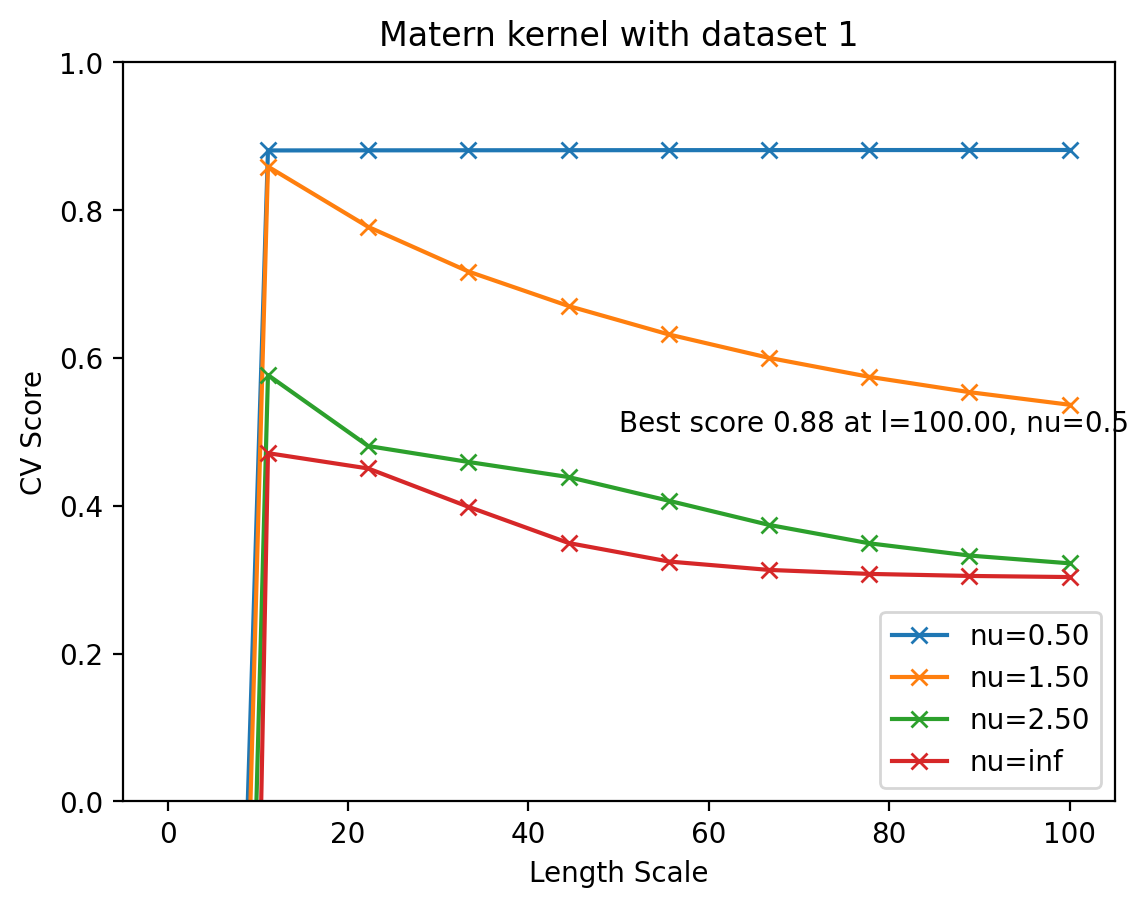

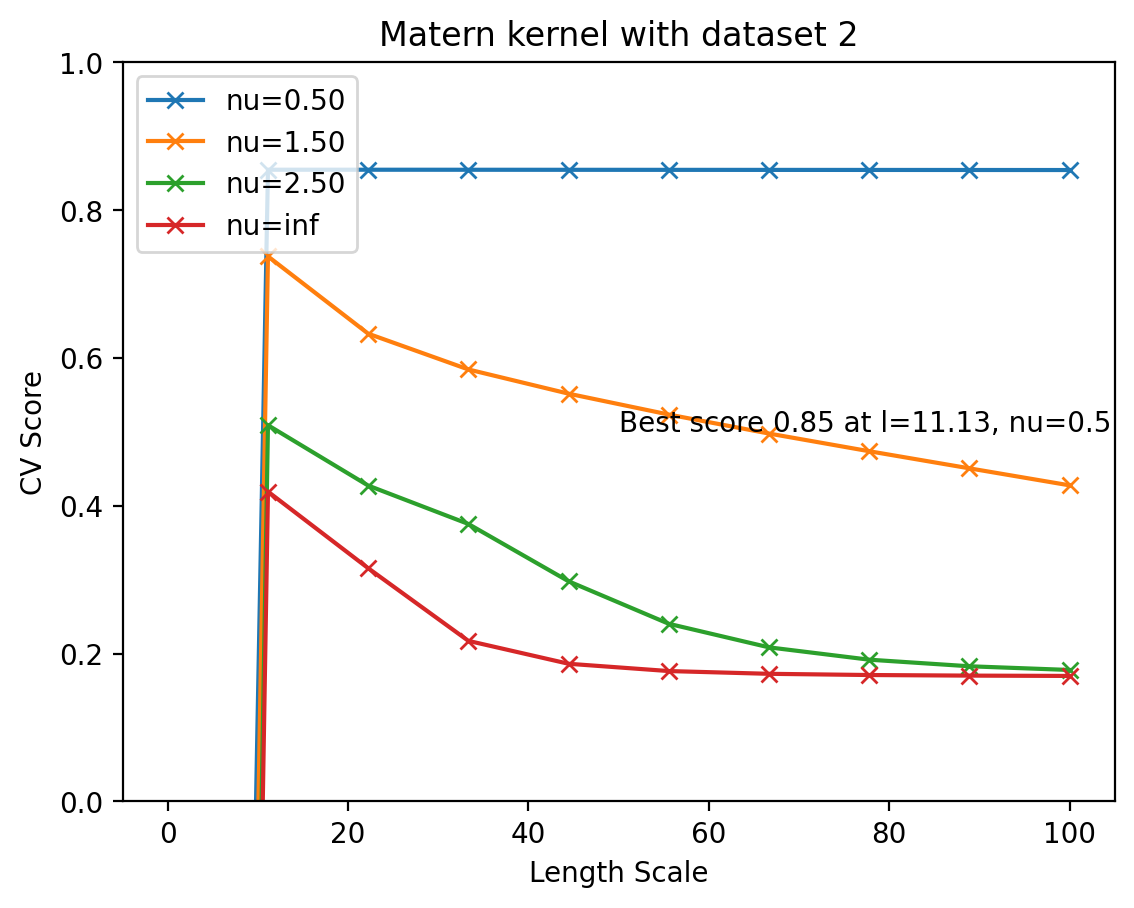

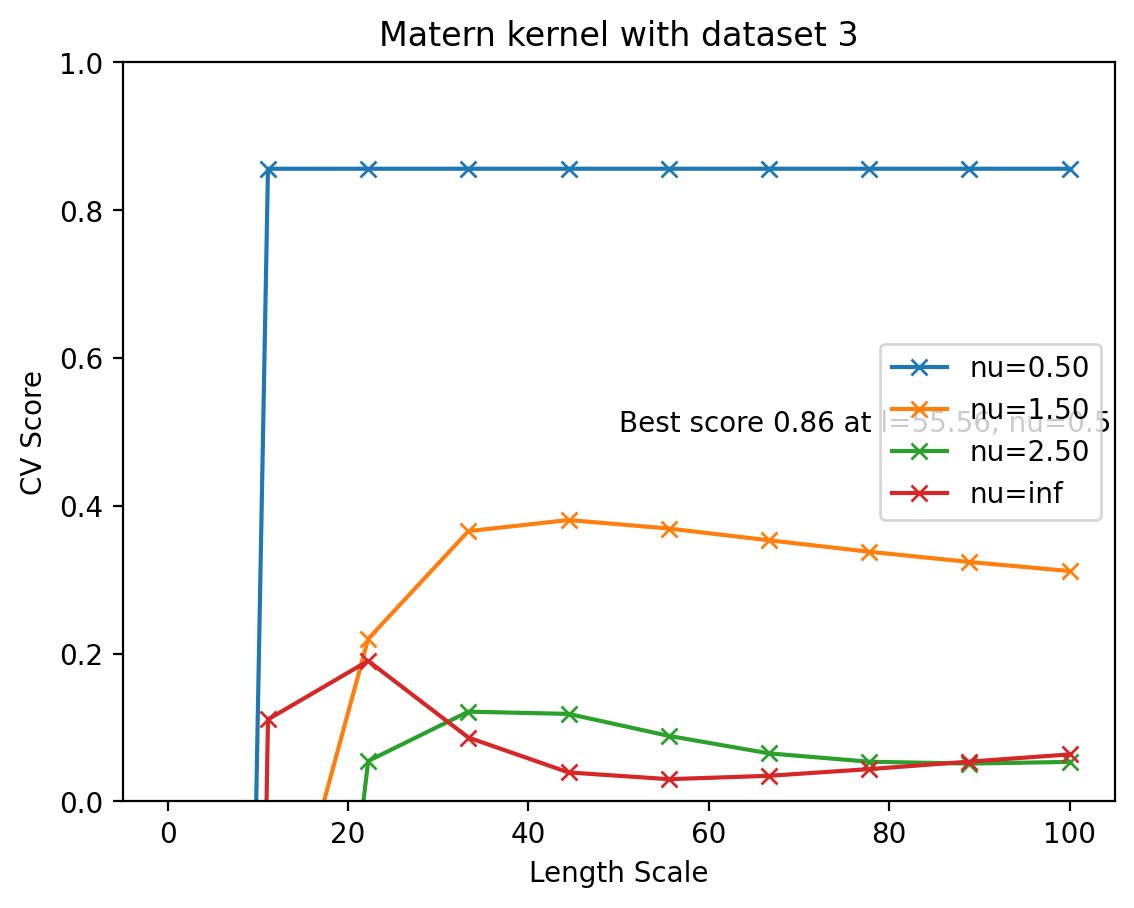

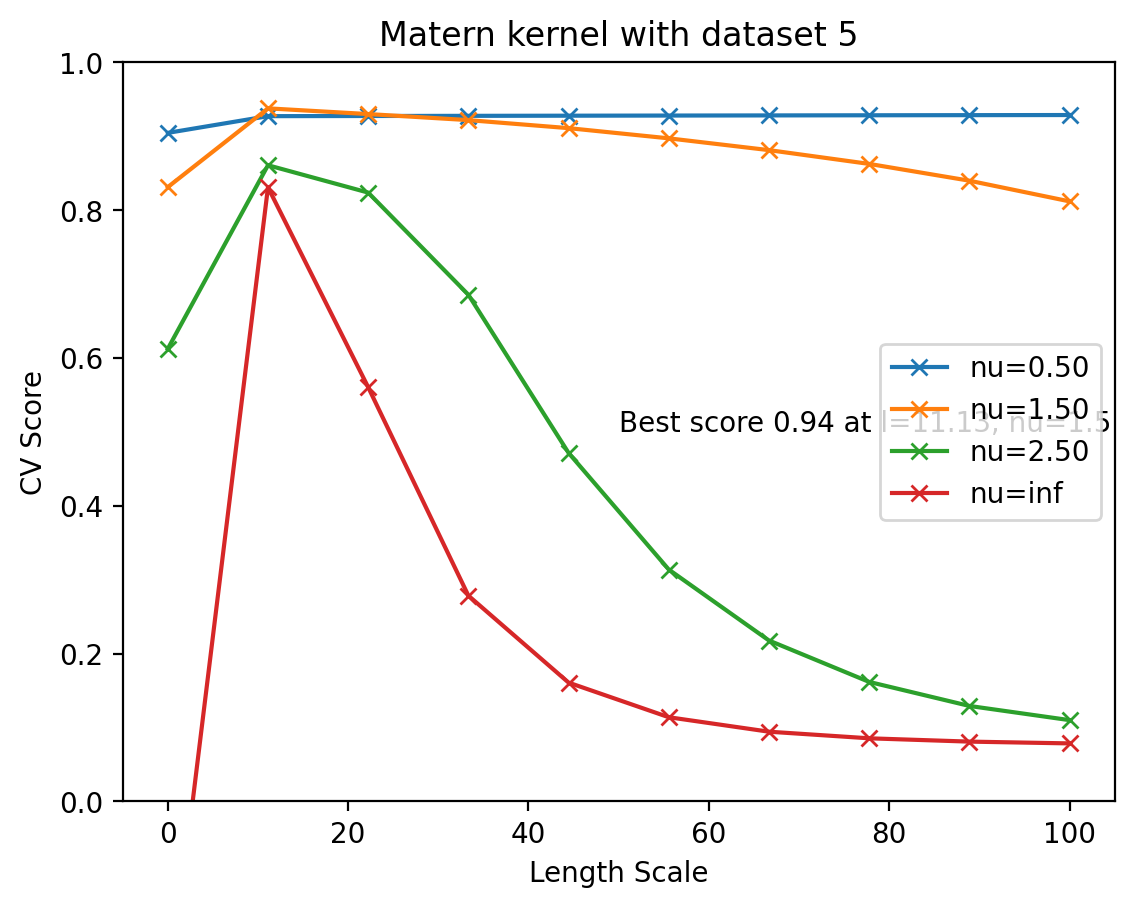

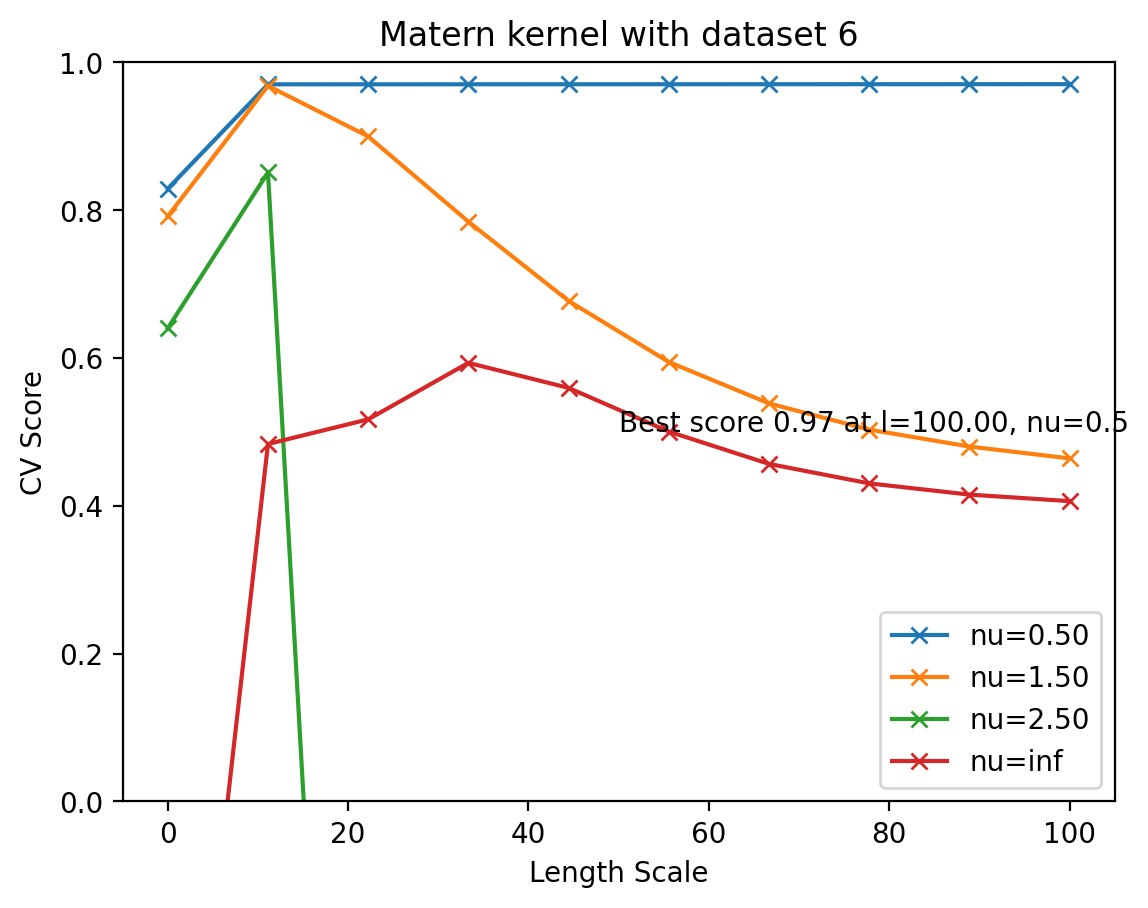

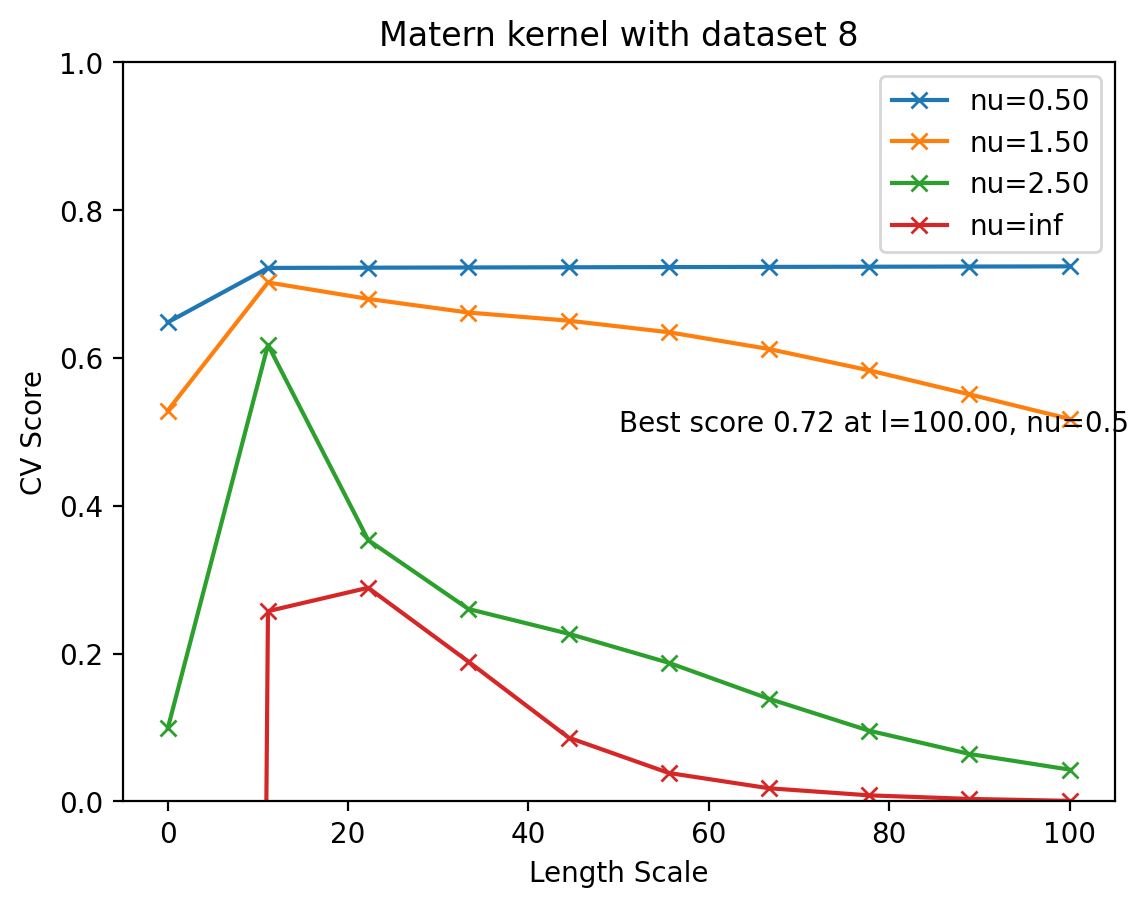

In [18]:
for run_idx in run_idx_range:
    result = results[run_idx].cv_results_['mean_test_score'].reshape(len(lc_range), len(nu_range))

    for i, nu in enumerate(nu_range):
        plt.plot(lc_range,result[:, i], label="nu=%.2f"%nu, marker='x') # 
        plt.ylim(0,1)
    best_lengh_scale = results[run_idx].best_params_["kernel__length_scale"]
    text = "Best score %.2f at l=%.2f, nu=%s"%(results[run_idx].best_score_, 
                                            results[run_idx].best_params_["kernel__length_scale"],
                                            results[run_idx].best_params_["kernel__nu"])
    plt.text((lc_range[0]+lc_range[-1])/2, 0.5, text)
    title = "Matern kernel with dataset %s"%run_idx
    plt.title(title)
    plt.xlabel("Length Scale")
    plt.ylabel("CV Score")
    plt.legend()
    fn = "../Graphs/MaternTuning/Matern_tuning_newXs_5D_exp%s_l%.2fto%.2f_n%d"%(run_idx, lc_range[0], lc_range[-1], len(lc_range))
    plt.savefig(fn+".png")
    plt.show()
    plt.close()


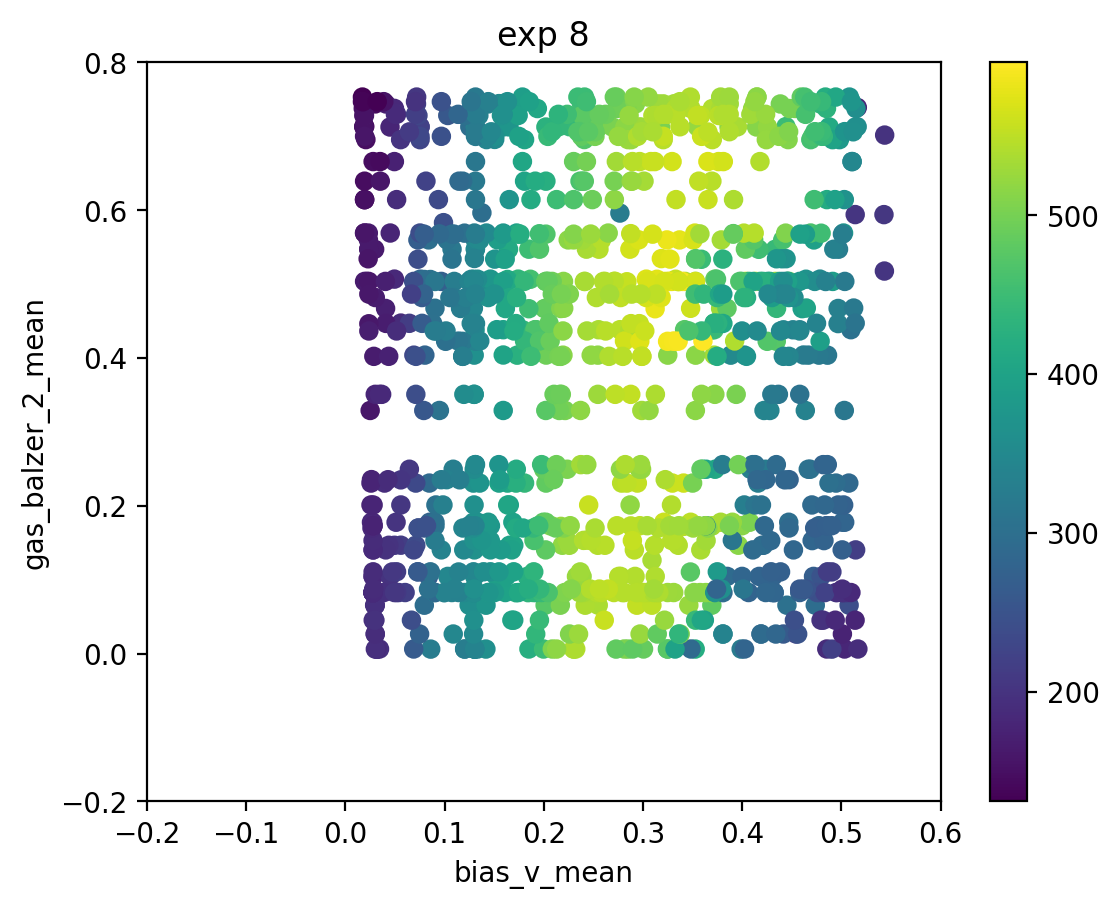

In [15]:
# data check
run_idx = "8"
X, y, X_var = loadXy(datafile, xcolumns=other_columns, run_idx=run_idx)
plt.title("exp %s"%run_idx)
cutoff = 30
plt.scatter(X[:,0][y>cutoff],X[:,1][y>cutoff],c=y[y>cutoff])
plt.xlabel(other_columns[0])
plt.ylabel(other_columns[1])
plt.xlim(-0.2, 0.6)
plt.ylim(-0.2, 0.8)
plt.colorbar()

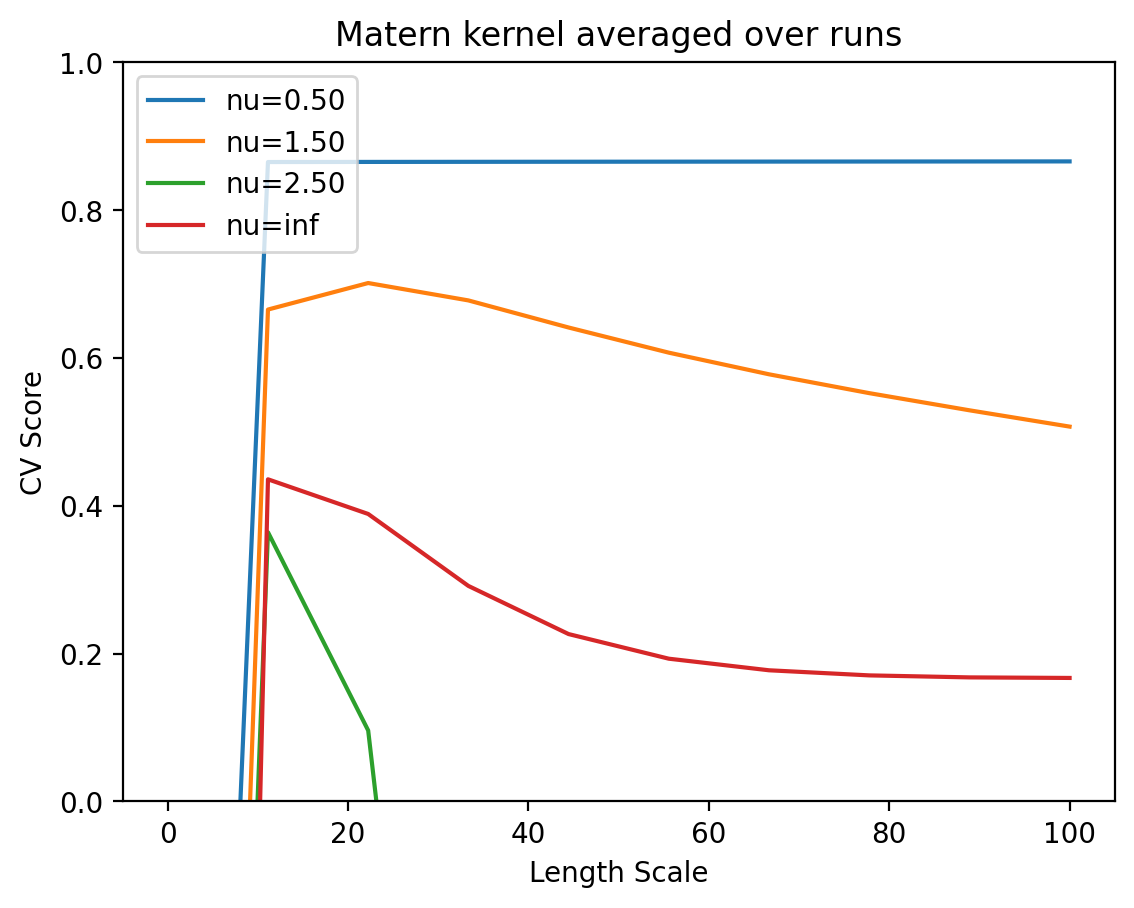

In [ ]:
result = np.zeros((len(lc_range), len(nu_range)))
for run_idx in run_idx_range:
    result += results[run_idx].cv_results_['mean_test_score'].reshape(len(lc_range), len(nu_range))
result /= len(run_idx_range)

for i, nu in enumerate(nu_range):
    plt.plot(lc_range,result[:, i], label="nu=%.2f"%nu, marker='x') # 
    plt.ylim(0,1)
title = "Matern kernel averaged over runs"
plt.title(title)
plt.xlabel("Length Scale")
plt.ylabel("CV Score")
plt.legend()
fn = "../Graphs/MaternTuning/Matern_tuning_newXs_5D_allexp_l%.2fto%.2f"%(lc_range[0], lc_range[-1])
plt.savefig(fn+".png")
plt.show()
plt.close()


In [6]:
result.max()

0.8658510193343295

In [6]:
from VenusOpt.utils import get_scaler, gpr_to_venus
run_idx = '1'
venus = gpr_to_venus(results[run_idx], get_scaler(xcolumns, use_datanorm=False), gpr_input_dim=5)
plotter.plot4d(venus.bbf, np.linspace(116, 128, 30), frame=plotter.Frame2D(97, 110, 97, 110), 
               func_name="Matern_newXs_best_fit_exp%s"%(run_idx), path="../Graphs/ModelGifs/", fps=5)

Animation saved as "../Graphs/ModelGifs/Matern_newXs_best_fit_exp1.gif"


'../Graphs/ModelGifs/Matern_newXs_best_fit_exp1.gif'

In [ ]:
venus.bbf(97,97,120)

82.76247454231543

### Finding out what's wrong with the new data

In [5]:
from VenusOpt.utils import MATERN_BEST_PARAMS
from VenusOpt.simulator import Venus

exp_num = '2'
old_data = False

datafile = "../Data/data%s.pkl"%exp_num if old_data else "../New Data/accumulated_weekend_data.h5"
X, y, X_var = loadXy(datafile, old=old_data, run_idx=exp_num)
X, y, X_var = sklearn.utils.shuffle(X,y,X_var)

gpr = GaussianProcessRegressor(
    kernel=Matern(), alpha=X_var.mean(), optimizer=None
)
gpr.set_params(**MATERN_BEST_PARAMS[exp_num])
gpr.fit(X, y)

venus = gpr_to_venus(gpr, get_scaler())

In [6]:
gpr.predict(np.array([[105,105,110]]), return_std=True)

(array([1.65646928e-06]), array([1.]))

In [4]:
plotter.plot4d(venus.bbf, np.linspace(116, 128, 30), bound2d=plotter.Bound2d(97, 110, 97, 110), 
               wbounds=(0, 1),
               func_name="Matern_tialfit_exp%s_datanorm_old%r"%(exp_num, old_data), fps=5, save_images=False)

'Matern_tialfit_exp2_datanorm_oldFalse.gif'